<a href="https://colab.research.google.com/github/Anil123K/Anil123K/blob/main/Audio_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf

In [5]:
CAPUCHIN_FILE= '/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC114131-3.wav'
NOT_CAPUCHIN_FILE ='/content/drive/MyDrive/data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

In [6]:
print("CAPUCHIN_FILE exists:", os.path.exists(CAPUCHIN_FILE))
print("NOT_CAPUCHIN_FILE exists:", os.path.exists(NOT_CAPUCHIN_FILE))

CAPUCHIN_FILE exists: True
NOT_CAPUCHIN_FILE exists: True


In [7]:
import librosa
import numpy as np
def load_wav_16k_mono(filename):
    # Load the audio file with librosa
    wav, sample_rate = librosa.load(filename, sr=None, mono=True)
    # Resample the audio to 16000 Hz if the original sample rate is different
    if sample_rate != 16000:
        wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
    return wav

In [8]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

In [9]:
'''
plt.plot(wave)
plt.plot(nwave)
plt.show()
'''

'\nplt.plot(wave)\nplt.plot(nwave)\nplt.show()\n'

In [10]:
POS = os.path.join('/content/drive/MyDrive/data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/drive/MyDrive/data', 'Parsed_Not_Capuchinbird_Clips')

In [11]:
POS

'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips'

In [12]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [13]:
len(pos)

217

In [14]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [15]:
positives.as_numpy_iterator().next()

(b'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC216012-10.wav', 1.0)

In [16]:
negatives.as_numpy_iterator().next()

(b'/content/drive/MyDrive/data/Parsed_Not_Capuchinbird_Clips/cardinal-bird-call-1.wav',
 0.0)

In [17]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC114132-0.wav', 1.0)

In [18]:
lengths = []
for file in os.listdir(os.path.join('/content/drive/MyDrive/data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [19]:
#lengths

In [20]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [21]:
'''def preprocess(file_path, label):
    # Convert the Tensor to a string if it is a Tensor
    if isinstance(file_path, tf.Tensor):
      file_path = file_path.numpy().decode('utf-8')

    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label
    '''

"def preprocess(file_path, label):\n    # Convert the Tensor to a string if it is a Tensor\n    if isinstance(file_path, tf.Tensor):\n      file_path = file_path.numpy().decode('utf-8')\n\n    wav = load_wav_16k_mono(file_path)\n    wav = wav[:48000]\n    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)\n    wav = tf.concat([zero_padding, wav],0)\n    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)\n    spectrogram = tf.abs(spectrogram)\n    spectrogram = tf.expand_dims(spectrogram, axis=2)\n    return spectrogram, label\n    "

In [22]:
#filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [23]:
#spectrogram, label = preprocess(filepath, label)

In [24]:
'''
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()
'''

'\nplt.figure(figsize=(30,20))\nplt.imshow(tf.transpose(spectrogram)[0])\nplt.show()\n'

In [25]:
#filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
#spectrogram, label = preprocess(filepath, label)

In [26]:
'''
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()
'''

'\nplt.figure(figsize=(30,20))\nplt.imshow(tf.transpose(spectrogram)[0])\nplt.show()\n'

In [27]:
'''
data = data.map(preprocess)
# data = data.map(lambda filepath, label: tf.py_function(
#     preprocess, [filepath, label], [tf.float32, tf.int32]
# ))
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)
'''

'\ndata = data.map(preprocess)\n# data = data.map(lambda filepath, label: tf.py_function(\n#     preprocess, [filepath, label], [tf.float32, tf.int32]\n# ))\ndata = data.cache()\ndata = data.shuffle(buffer_size=1000)\ndata = data.batch(16)\ndata = data.prefetch(8)\n'

In [28]:
#import numpy as np
def preprocess(file_path, label):
    # Define a wrapper function for use with tf.py_function
    def _load_wav_16k_mono(file_path):
        wav = load_wav_16k_mono(file_path.numpy().decode('utf-8'))
        return wav.astype(np.float32)

    # Use tf.py_function to wrap the Python function
    wav = tf.py_function(_load_wav_16k_mono, [file_path], tf.float32)

    # Fix the shape information after using py_function
    wav.set_shape([None])

    # Trim or pad the waveform to 48000 samples
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)

    # Compute the spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)

    return spectrogram, label

# Example of how to use preprocess function in a data pipeline
def create_dataset(file_paths, labels, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


In [29]:
#train = data.take(36)
#test = data.skip(36).take(15)

In [30]:
capuchin_files = [os.path.join(POS, f) for f in os.listdir(POS) if f.endswith('.wav')]
not_capuchin_files = [os.path.join(NEG, f) for f in os.listdir(NEG) if f.endswith('.wav')]

In [31]:
file_paths = capuchin_files + not_capuchin_files
labels = [0] * len(capuchin_files) + [1] * len(not_capuchin_files)

assert len(file_paths) == len(labels)
assert len(file_paths) > 0

print(f"Total file paths: {len(file_paths)}")
print(f"Total labels: {len(labels)}")

# Create dataset
#data = create_dataset(file_paths, labels)
data = create_dataset(file_paths, labels, batch_size=16)

# Check the dataset size
data_size = sum(1 for _ in data)
assert data_size > 0

# Split dataset into train and test

train_size = int(0.8 * data_size)  #len(file_paths)
test_size = data_size - train_size
print(f"Training size: {train_size}")
print(f"Test size: {test_size}")

train = data.take(train_size)
#test = data.skip(train_size).take(len(file_paths) - train_size)
test = data.skip(train_size).take(test_size)
# .take(data_size - train_size)




Total file paths: 816
Total labels: 816
Training size: 40
Test size: 11


In [32]:
train_size_check = sum(1 for _ in train)
test_size_check = sum(1 for _ in test)
print(f"Verified training size: {train_size_check}")
print(f"Verified test size: {test_size_check}")
assert train_size_check > 0
assert test_size_check > 0

Verified training size: 40
Verified test size: 11


In [33]:
# Verify the dataset
#for spectrogram, label in train.take(1):
 #   print(spectrogram.shape, label.numpy())

In [34]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [35]:
spectrogram, label = preprocess(filepath, label)

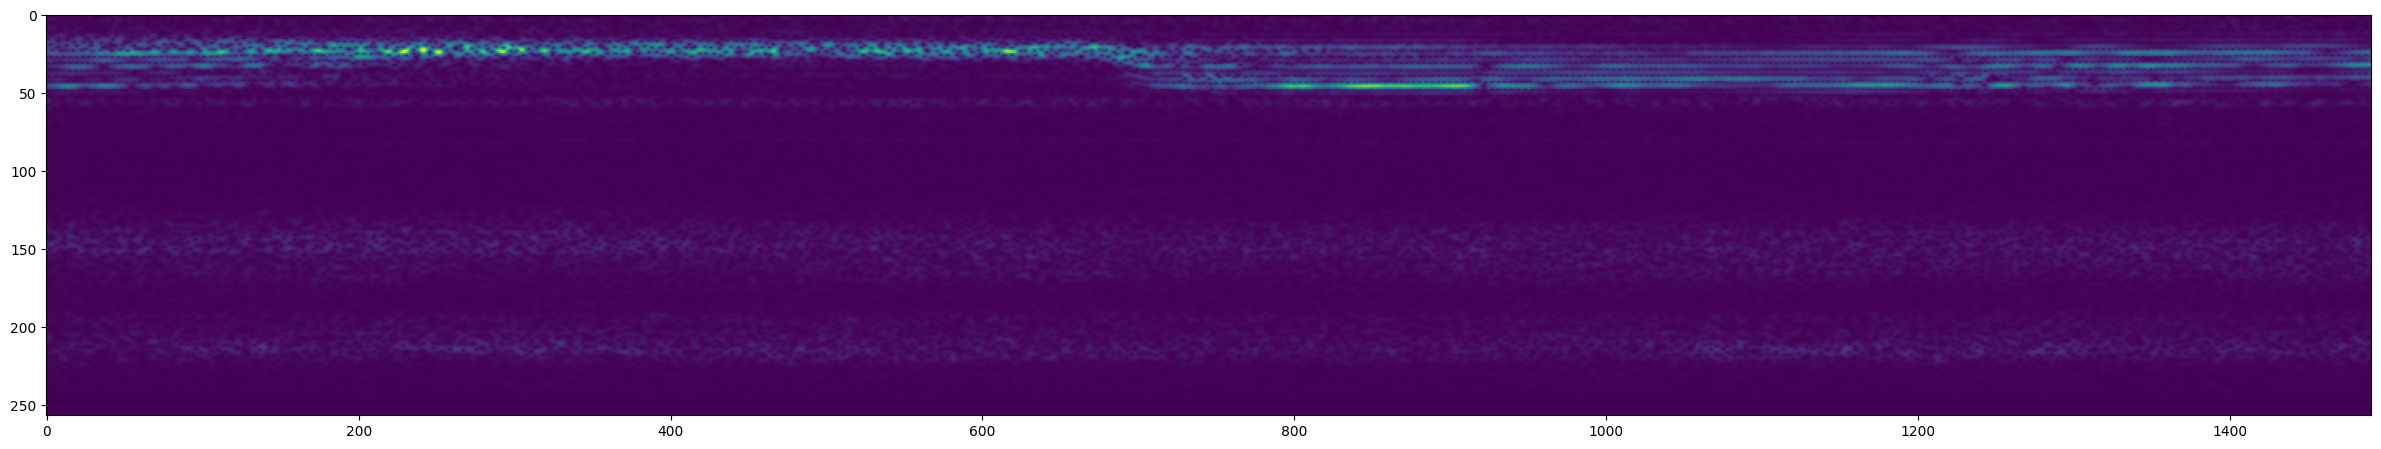

In [36]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [37]:
samples, labels = train.as_numpy_iterator().next()

In [38]:
samples.shape

(16, 1491, 257, 1)

In [39]:
labels

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0], dtype=int32)

In [40]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [41]:
'''
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
'''

"\nmodel = Sequential()\nmodel.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))\nmodel.add(Conv2D(16, (3,3), activation='relu'))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dense(1, activation='sigmoid'))\n"

In [42]:
#model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [43]:
#from sklearn.model_selection import train_test_split
# Assuming 'X' and 'y' are your features and labels
#X_train, X_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2)

# Then fit the model:


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.metrics import Precision

model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(1491, 257, 1)),
    Conv2D(8, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision()])


In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 64)                192620096 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 192620825 (734.79 MB)
Trainable params: 192620825 (734.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
#hist = model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test))

In [47]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
40/40 [==============================] - 324s 8s/step - loss: 2.6997 - accuracy: 0.9328 - precision: 0.9737 - val_loss: 0.5397 - val_accuracy: 0.9602 - val_precision: 0.9542
Epoch 2/4
40/40 [==============================] - 317s 8s/step - loss: 0.3395 - accuracy: 0.9781 - precision: 0.9812 - val_loss: 0.3706 - val_accuracy: 0.9943 - val_precision: 1.0000
Epoch 3/4
40/40 [==============================] - 328s 8s/step - loss: 0.1161 - accuracy: 0.9969 - precision: 0.9979 - val_loss: 0.0010 - val_accuracy: 1.0000 - val_precision: 1.0000
Epoch 4/4
40/40 [==============================] - 316s 8s/step - loss: 0.0028 - accuracy: 0.9984 - precision: 0.9979 - val_loss: 0.0033 - val_accuracy: 1.0000 - val_precision: 1.0000


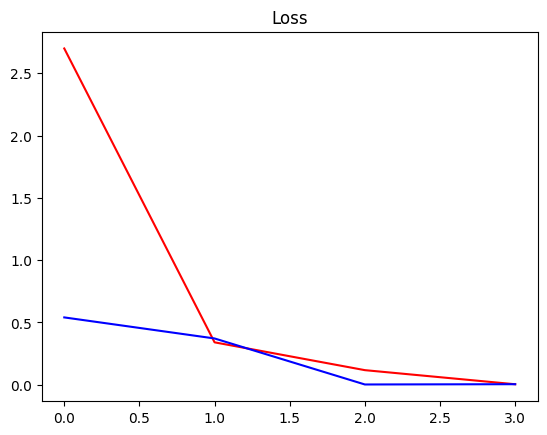

In [48]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

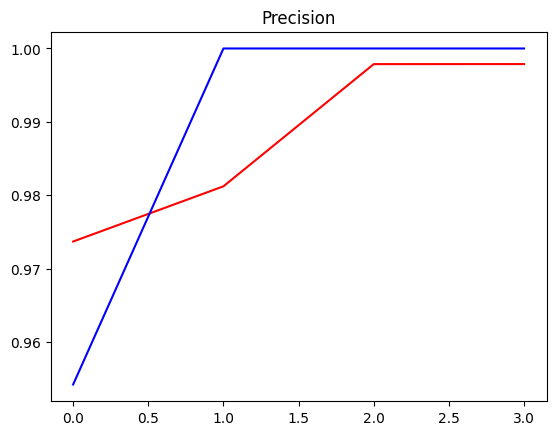

In [49]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [50]:
X_test, y_test = test.as_numpy_iterator().next()

In [51]:
yhat = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [52]:
yhat

array([[1.0000000e+00],
       [1.0000000e+00],
       [9.7333294e-01],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.6379012e-08],
       [1.0000000e+00],
       [9.9488229e-01],
       [1.0000000e+00],
       [9.9999017e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [53]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [54]:
tf.math.reduce_sum(yhat)


<tf.Tensor: shape=(), dtype=int32, numpy=13>

In [55]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=int32, numpy=13>

In [56]:
'''
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav
    '''

'\ndef load_mp3_16k_mono(filename):\n    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """\n    res = tfio.audio.AudioIOTensor(filename)\n    # Convert to tensor and combine channels \n    tensor = res.to_tensor()\n    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 \n    # Extract sample rate and cast\n    sample_rate = res.rate\n    sample_rate = tf.cast(sample_rate, dtype=tf.int64)\n    # Resample to 16 kHz\n    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)\n    return wav\n    '

In [57]:
def load_mp3_16k_mono(filename):
    """ Load an MP3 file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    # Load the audio file with librosa
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    # Convert the numpy array to a tensor
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    return wav

In [58]:
mp3 = os.path.join('/content/drive/MyDrive/data', 'Forest Recordings', 'recording_00.mp3')

In [59]:
print("mp3 exists:", os.path.exists(mp3))

mp3 exists: True


In [60]:
wav = load_mp3_16k_mono(mp3)
print(wav.shape)

(2880667,)


In [61]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [62]:
samples, index = audio_slices.as_numpy_iterator().next()

In [63]:
samples.shape

(1, 48000)

In [64]:
len(audio_slices)

60

In [65]:
# Build Function to Convert Clips into Windowed Spectrograms

In [66]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [67]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [68]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 16s 5s/step


In [69]:
from itertools import groupby

In [70]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [71]:
calls

7

In [ ]:
# Making Predictions

In [73]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/data', 'Forest Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 5s 5s/step


In [74]:
results

{'recording_00.mp3': array([[9.9694300e-01],
        [9.9976647e-01],
        [9.9957442e-01],
        [1.1435996e-02],
        [0.0000000e+00],
        [1.0000000e+00],
        [9.9995703e-01],
        [9.9948293e-01],
        [9.9999589e-01],
        [9.9898756e-01],
        [9.9983430e-01],
        [9.9988747e-01],
        [9.9953806e-01],
        [2.3658890e-09],
        [0.0000000e+00],
        [9.9977160e-01],
        [1.0000000e+00],
        [9.9995732e-01],
        [9.9952507e-01],
        [9.9628538e-01],
        [9.9324322e-01],
        [9.9990487e-01],
        [9.9664903e-01],
        [8.3712816e-01],
        [0.0000000e+00],
        [9.9999988e-01],
        [9.9999958e-01],
        [9.8781735e-01],
        [9.9991846e-01],
        [9.9646091e-01],
        [9.9992925e-01],
        [9.7839451e-01],
        [9.9999982e-01],
        [9.9999076e-01],
        [9.2923880e-01],
        [9.9992526e-01],
        [0.0000000e+00],
        [1.0000000e+00],
        [9.9977875e-01],
     

In [ ]:
# Convert Predictions into Classes

In [75]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'recording_01.mp3': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'recording_02.mp3': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'recording_03.mp3': [1,
  1,
  1,
  

In [ ]:
# Group Consecutive Detections

In [76]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 12,
 'recording_01.mp3': 1,
 'recording_02.mp3': 1,
 'recording_03.mp3': 1,
 'recording_04.mp3': 3,
 'recording_05.mp3': 1,
 'recording_06.mp3': 5,
 'recording_07.mp3': 3,
 'recording_08.mp3': 12,
 'recording_09.mp3': 1,
 'recording_10.mp3': 4,
 'recording_11.mp3': 2,
 'recording_12.mp3': 5,
 'recording_13.mp3': 1,
 'recording_14.mp3': 1,
 'recording_15.mp3': 3,
 'recording_16.mp3': 1,
 'recording_17.mp3': 5,
 'recording_18.mp3': 13,
 'recording_19.mp3': 5,
 'recording_20.mp3': 1,
 'recording_21.mp3': 2,
 'recording_22.mp3': 17,
 'recording_23.mp3': 1,
 'recording_24.mp3': 1,
 'recording_25.mp3': 10,
 'recording_27.mp3': 1,
 'recording_26.mp3': 17,
 'recording_29.mp3': 1,
 'recording_28.mp3': 15,
 'recording_30.mp3': 4,
 'recording_31.mp3': 6,
 'recording_32.mp3': 16,
 'recording_35.mp3': 19,
 'recording_34.mp3': 17,
 'recording_33.mp3': 1,
 'recording_36.mp3': 1,
 'recording_37.mp3': 7,
 'recording_38.mp3': 4,
 'recording_42.mp3': 1,
 'recording_41.mp3': 1,
 'reco

In [ ]:
# Export Results

In [77]:
import csv

In [78]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])